In [1]:
import time
import os
# os.environ["MKL_THREADING_LAYER"] = "GNU"
import keras
import theano
import numpy as np
import pandas as pd
import decimal
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

print 'theano version:', theano.__version__
print 'theano config device:', theano.config.device, theano.config.floatX
print 'keras version:', keras.__version__
print 'pandas version:', pd.__version__
print 'numpy version:', np.__version__

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


theano version: 1.0.3
theano config device: cpu float32
keras version: 2.2.4
pandas version: 0.23.4
numpy version: 1.15.3


In [23]:
test = pd.read_csv('test.csv')
train = pd.read_csv('training.csv')

test['Image'] = test.Image.apply(lambda im: np.fromstring(im, sep=' '))
train['Image'] = train.Image.apply(lambda im: np.fromstring(im, sep=' '))

In [24]:
train.iloc[:5,:5]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x
0,66.033564,39.002274,30.227008,36.421678,59.582075
1,64.332936,34.970077,29.949277,33.448715,58.856170
2,65.057053,34.909642,30.903789,34.909642,59.412000
3,65.225739,37.261774,32.023096,37.261774,60.003339
4,66.725301,39.621261,32.244810,38.042032,58.565890


In [25]:
print train.count()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [29]:
train = train.dropna()
# train = train.sample(frac=1).reset_index(drop=True)
train_data = train.Image
train_labels = train[train.columns[:-1]]
train_data.shape, train_labels.shape

((2140L,), (2140, 30))

In [40]:
idx = np.random.randint(0, len(train_data), 16)

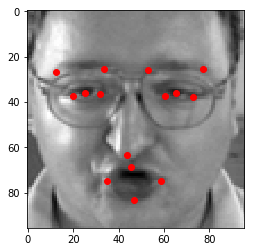

In [46]:
img = train_data.iloc[loc].reshape(96,96)
plt.imshow(img, cmap='gray')
for c in range(0, len(train_labels.columns)-1, 2):
    x = train_labels[train_labels.columns[c]].iloc[loc]
    y = train_labels[train_labels.columns[c+1]].iloc[loc]
    plt.scatter(x, y, c='r')

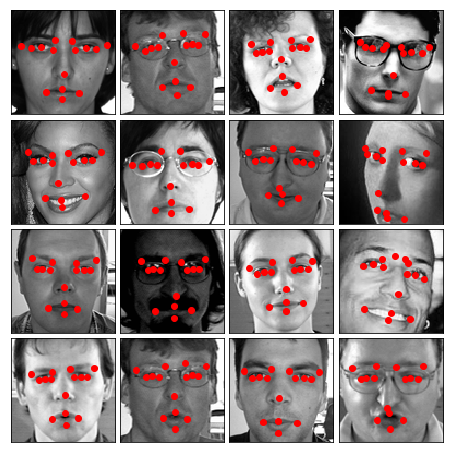

In [56]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i, loc in enumerate(idx):
    img = train_data.iloc[loc].reshape(96,96)
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(img, cmap='gray')
    for c in range(0, len(train_labels.columns)-1, 2):
        x = train_labels[train_labels.columns[c]].iloc[loc]
        y = train_labels[train_labels.columns[c+1]].iloc[loc]
        plt.scatter(x, y, c='r')

In [ ]:
# print out some examples of the predictions

### PSEUDOCODE ###
fig = plt.figure(figsize=12,8)
idx = np.random.randint(0, len(test_data), size=16)
for i in idx:
    img = test_data[i].reshape(96, 96)
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(img, cmap='gray')
    for c in range(0, len(pred.columns)-1, 2):
        x_pred = pred[pred.columns[c]][0]
        y_pred = pred[pred.columns[c+1]][0]
        ax.scatter(x_pred, y_pred, c='r')

In [20]:
train_labels.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,71.079000,39.584208,26.331576,38.054388,NaN,NaN,NaN,NaN,NaN,NaN,...,47.366640,69.798240,NaN,NaN,NaN,NaN,NaN,NaN,46.984200,81.271920
1,64.399591,38.503814,29.440197,39.945433,NaN,NaN,NaN,NaN,NaN,NaN,...,46.739687,63.732223,NaN,NaN,NaN,NaN,NaN,NaN,48.181306,75.265206
2,69.260800,40.359393,28.490869,36.186097,NaN,NaN,NaN,NaN,NaN,NaN,...,45.826152,75.671945,NaN,NaN,NaN,NaN,NaN,NaN,45.184110,84.981572
3,73.352348,38.401461,32.468452,38.401461,NaN,NaN,NaN,NaN,NaN,NaN,...,49.224209,76.604661,NaN,NaN,NaN,NaN,NaN,NaN,49.894330,88.668730
4,65.515296,36.871904,29.650475,40.187136,NaN,NaN,NaN,NaN,NaN,NaN,...,51.350197,66.106251,NaN,NaN,NaN,NaN,NaN,NaN,52.254357,77.558827


# Single hidden layer perceptron

In [2]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt

In [3]:
batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_x, img_y = 28, 28

# load the MNIST data set, which already splits into train and test sets for us
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000L, 28L, 28L), (60000L,), (10000L, 28L, 28L), (10000L,))

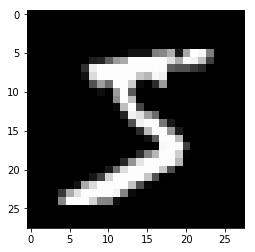

In [5]:
plt.imshow(x_train[0], cmap='gray')

In [6]:
img_x, img_y

(28, 28)

In [7]:
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)
input_shape, x_train.shape, y_train.shape

((28, 28, 1), (60000L, 28L, 28L, 1L), (60000L,))

In [8]:
# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000L, 28L, 28L, 1L)
60000 train samples
10000 test samples


In [9]:
# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train.shape, y_test.shape

((60000L, 10L), (10000L, 10L))

In [10]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

ImportError: ('The following error happened while compiling the node', DotModulo(A, s, m, A2, s2, m2), '\n', 'DLL load failed: The specified procedure could not be found.')

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 11), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()